In [1]:
import numpy as np # linear algebra
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

### Data pre-processing

In [7]:
tweets = pd.read_csv('socialmedia-disaster-tweets.csv', encoding='ansi')

In [8]:
tweets.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [9]:
tweets = tweets.drop(labels=['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'choose_one:confidence', 'choose_one_gold', 'keyword', 'location', 'tweetid', 'userid'], axis=1)

Let's convert String category variables to Integer category variables.

In [10]:
tweets.choose_one = tweets.choose_one.replace(to_replace=['Relevant', 'Not Relevant', 'Can\'t Decide'], value=[1, 0, 0])

In [11]:
tweets.head()

,choose_one,text
0,1,Just happened a terrible car crash
1,1,Our Deeds are the Reason of this #earthquake M...
2,1,"Heard about #earthquake is different cities, s..."
3,1,"there is a forest fire at spot pond, geese are..."
4,1,Forest fire near La Ronge Sask. Canada


### Build Vocabulary

In [12]:
vocabulary = []

all_tweets = tweets.text.values

In [19]:
print(all_tweets[0:50])

['Just happened a terrible car crash'
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Heard about #earthquake is different cities, stay safe everyone.'
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 'Apocalypse lighting. #Spokane #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 'Typhoon Soudelor kills 28 in China and Taiwan'
 "We're shaking...It's an earthquake"
 "I'm on top of the hill and I can se

In [13]:
for tweet in all_tweets:
    words = tweet.split()
    for word in words:
        if word.lower() not in vocabulary and word.isalnum():
            vocabulary.append(word.lower())
vocabulary = sorted(vocabulary)
print(len(vocabulary))

14325


In [15]:
pad_char = "$0$"
if pad_char not in vocabulary:
    vocabulary.append(pad_char)
vocab_size = len(vocabulary)
print(vocab_size)

14326


In [10]:
print(vocabulary[0:10], vocabulary[-1])

['0', '02', '03', '04', '05', '05th', '06', '061', '06jst', '06jst'] $0$


Just keep the columns with features.

In [16]:
X = tweets.drop(labels=['choose_one'], axis=1).values
y = tweets.choose_one.values

In [17]:
print(X[:10], y[:10])
print(len(X))

[['Just happened a terrible car crash']
 ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
 ['Heard about #earthquake is different cities, stay safe everyone.']
 ['there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all']
 ['Forest fire near La Ronge Sask. Canada']
 ["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"]
 ['13,000 people receive #wildfires evacuation orders in California ']
 ['Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']
 ['#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires']
 ['Apocalypse lighting. #Spokane #wildfires']] [1 1 1 1 1 1 1 1 1 1]
10876


In [13]:
X = [x[0].split() for x in X]

In [14]:
print(X[:10], y[:10])

[['Just', 'happened', 'a', 'terrible', 'car', 'crash'], ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], ['Heard', 'about', '#earthquake', 'is', 'different', 'cities,', 'stay', 'safe', 'everyone.'], ['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'pond,', 'geese', 'are', 'fleeing', 'across', 'the', 'street,', 'I', 'cannot', 'save', 'them', 'all'], ['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask.', 'Canada'], ['All', 'residents', 'asked', 'to', "'shelter", 'in', "place'", 'are', 'being', 'notified', 'by', 'officers.', 'No', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected'], ['13,000', 'people', 'receive', '#wildfires', 'evacuation', 'orders', 'in', 'California'], ['Just', 'got', 'sent', 'this', 'photo', 'from', 'Ruby', '#Alaska', 'as', 'smoke', 'from', '#wildfires', 'pours', 'into', 'a', 'school'], ['#RockyFire', 'Update', '=>', 'California', 'Hwy.', '20', 'closed', 'in', 'both', 'direct

In [20]:
def string_to_vocab(lines):
    X_onehot = []

    for line in lines:
        temp_X = np.array([vocabulary.index(word.lower()) for word in line if word.isalnum() or word == pad_char])
        temp_oh_X = np.zeros((len(temp_X), vocab_size))
        temp_oh_X[np.arange(len(temp_X)),temp_X] = 1
        X_onehot.append(temp_oh_X)
        
    return X_onehot

In [16]:
def string_to_word_ids(lines):
    X_word_ids = []

    for line in lines:
        temp_X = np.array([vocabulary.index(word.lower()) for word in line if word.isalnum() or word == pad_char])
        X_word_ids.append(temp_X)
        
    return X_word_ids

In [17]:
string_to_word_ids([X[0], X[1]])

[array([21410, 15821,   537, 37350,  6717,  8724]),
 array([28393,  9594,  2799, 37595, 31189, 27528, 38753, 24100,  1878,
        13881, 41124,  1788])]

In [18]:
def pad_to_max(X):
    padded_X = []
    cleared_X = []
    
    for x in X:
        tempx = [word for word in x if word.isalnum()]
        cleared_X.append(tempx)
    # print(cleared_X)
    
    cleaned_lengths = [len(x) for x in cleared_X]
    max_len = max(cleaned_lengths)
    
    for x in cleared_X:
        tempx = [word for word in x if word.isalnum()]
        tempx.extend([pad_char]*(max_len-len(x)))
        padded_X.append(tempx)
    
    return padded_X, cleaned_lengths

In [19]:
def get_feed_dict(feed_X, feed_Y):
    feed_dict = {}
    feed_dict['data'], feed_dict['seq_length'] = pad_to_max(feed_X)
    feed_dict['data'] = string_to_word_ids(feed_dict['data'])
    feed_dict['labels'] = feed_Y
    
    return feed_dict

In [20]:
print_x = pad_to_max(X[0:10])

for x in print_x:
    print(x)

[['Just', 'happened', 'a', 'terrible', 'car', 'crash', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$'], ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', 'May', 'ALLAH', 'Forgive', 'us', 'all', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$'], ['Heard', 'about', 'is', 'different', 'stay', 'safe', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$'], ['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'geese', 'are', 'fleeing', 'across', 'the', 'I', 'cannot', 'save', 'them', 'all', '$0$', '$0$'], ['Forest', 'fire', 'near', 'La', 'Ronge', 'Canada', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$', '$0$'], ['All', 'residents', 'asked', 'to', 'in', 'are', 'being', 'notified', 'by', 'No', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected'], ['people', 'receive', 'evacuation', 'orders', 'in', 'California', '$0$', '$0$', '$0$', '$0$', '$0$', 

In [21]:
print(get_feed_dict(X[0:10], y[0:10]))

{'data': [array([21410, 15821,   537, 37350,  6717,  8724, 44531, 44531, 44531,
       44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531,
       44531]), array([28393,  9594,  2799, 37595, 31189, 27528, 38753, 24100,  1878,
       13881, 41124,  1788, 44531, 44531, 44531, 44531, 44531, 44531,
       44531]), array([16271,  1051, 20452, 10161, 35872, 32913, 44531, 44531, 44531,
       44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531,
       44531]), array([38559, 20452,   537, 13824, 13169,  3301, 35540, 14670,  2799,
       13481,  1209, 37595, 17493,  6660, 33225, 38513,  1788, 44531,
       44531]), array([13824, 13169, 26075, 21980, 32434,  6628, 44531, 44531, 44531,
       44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531, 44531,
       44531]), array([ 1788, 31831,  3235, 39336, 19597,  2799,  4469, 27045,  6178,
       26659, 28374, 12013, 28274, 34165, 19597, 29560, 28326,  2799,
       12238]), array([29144, 31218, 12013, 28326, 19597,  6372, 44531

In [22]:
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

Randomly select indexes to use for training.

In [23]:
train_index = np.random.choice(len(X), round(len(X) * 0.6), replace=False)

In [24]:
train_index, len(train_index)

(array([ 7405, 10573,  2013, ...,  4736,  2978,  1604]), 6526)

In [25]:
test_index = np.array(list(set(range(len(X))) - set(train_index)))
X = np.array(X)
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [26]:
test_index, len(test_index)

(array([8192,    1, 8194, ..., 8188, 8189, 8191]), 4350)

In [27]:
train_X[0:10], train_y[0:10]

(array([list(["I'm", 'about', 'to', 'be', 'obliterated']),
        list(['#Insurance:', 'Texas', 'Seeks', 'Comment', 'on', 'Rules', 'for', 'Changes', 'to', 'Windstorm', 'Insurer', 'http://t.co/rb02svlpPu']),
        list(['lets', 'hope', 'this', 'concert', 'ends', 'with', 'zero', 'casualties', 'amen']),
        list(['Storm', 'in', 'RI', 'worse', 'than', 'last', 'hurricane.', 'My', 'city&amp;3others', 'hardest', 'hit.', 'My', 'yard', 'looks', 'like', 'it', 'was', 'bombed.', 'Around', '20000K', 'still', 'without', 'power']),
        list(['Tell', '@BarackObama', 'to', 'rescind', 'medals', 'of', "'honor'", 'given', 'to', 'US', 'soldiers', 'at', 'the', 'Massacre', 'of', 'Wounded', 'Knee.', 'SIGN', 'NOW', '&amp;', 'RT!', 'https://t.co/u4r8dRiuAc']),
        list(["I'm", 'more', 'into', 'the', 'healing/reviving', 'side', 'of', 'the', 'game', 'rather', 'than', 'better', 'attacking', 'so', 'for', 'now', 'Siren', '&gt;', 'all', 'other', 'characters', '(except', 'new', 'girl).']),
        list(

### Building Tensorflow Graph
Let's start building Tensorflow model. Tensorflow is a graph based framework. So we have to build the whole graph of our model before we start any kind of training. For most ML problems, the graph building process is pretty straight forward.

- Step 1: Define placeholders for input Data and Labels.
- Step 2: Pass the Data through the layers.
- Step 3: Define a loss function.
- Step 4: Apply Gradient Descent (or other optimisers) on the loss.

Placeholders are special type of Tensorflow variables. These variables don't hold any particular values and are used as input nodes to the graph. The data is fed to these variables in order to Train the model or infer using the model.

- "data" is used for data input. The shape is Batch Size x Input Features. 
- "labels" is used for output labels. Batch Size x Output Space

To keep the batch size "variable", we use None instead of a specific Batch Size.

In [28]:
data = tf.placeholder(dtype=tf.int32, shape=[None, None], name='Data_Input')
labels = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='Labels_Input')
seq_lengths = tf.placeholder(dtype=tf.int32, shape=[None], name='Seq_Lengths')
keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name="dropout")

In [29]:
data

<tf.Tensor 'Data_Input:0' shape=(?, ?) dtype=int32>

In [30]:
data.shape

TensorShape([Dimension(None), Dimension(None)])

Now pass the data through all layers.

In [31]:
word_embeddings = tf.one_hot(data, vocab_size)

In [32]:
size_lstm = 32

cell_fw = tf.contrib.rnn.LSTMCell(size_lstm)
cell_bw = tf.contrib.rnn.LSTMCell(size_lstm)

(output_fw, output_bw), _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw, cell_bw, word_embeddings,
    sequence_length=seq_lengths, dtype=tf.float32)

lstm = tf.concat([output_fw, output_bw], axis=-1)
output = tf.nn.dropout(lstm, keep_prob)

lstm_shape = tf.shape(output)
reshaped_lstm = tf.reshape(output, [lstm_shape[1], lstm_shape[0], lstm_shape[2]])
output = tf.reshape(reshaped_lstm[-1], [-1, 2*size_lstm])

Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead


In [33]:
logits = tf.layers.dense(output, units=1)

Once we have the logits calculated, lets add the loss operation. Since we're doing logistic regression, the loss function is sigmoid cross entropy.

In [34]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [49]:
learning_rate = 0.003
batch_size = 32
iter_num = 10000

To train our model, we iterate on the parameter values such that the loss is minimized. To reduce the loss, we have multiple Optimizers available. Let's use Gradient Descent.

In [36]:
opt = tf.train.AdamOptimizer(learning_rate)

In [37]:
goal = opt.minimize(loss)

Prediction and Accuracy utility operations.

In [38]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(logits), name='Prediction')
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, labels), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct, name='Accuracy')

tf.summary.scalar('accuracy', accuracy)
# End of the definition of the model framework

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [39]:
merged = tf.summary.merge_all()

In [40]:
loss_trace = []
train_acc = []
test_acc = []

### Training / Evaluating the model
Up until now, we have just built the graph of model in Tensorflow. Now we will start trainig and evaluating the model. To use the model:
- Initialise the model.
- To "Train" the model: feed data and labels and process the model till the "goal" operation.
- To "Evaluate" the model: provide data and lables and process till "accuracy" operation.

Initialisation is pretty standard. We get a session object after initialisation and this session object is used to interact with the graph.

In [41]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [42]:
train_writer = tf.summary.FileWriter('./text_classification_logs', sess.graph)

To train the model:
- Get a batch of data and labels.
- Feed data and labels to the graph.
- Check the Train and Test data accuracy.

In [53]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    feed_dict = get_feed_dict(batch_train_X, batch_train_y)
    
    _, summary = sess.run([goal, merged], feed_dict={data: feed_dict['data'], 
                                                     labels: feed_dict['labels'],
                                                     seq_lengths: feed_dict['seq_length'],
                                                     keep_prob: 0.5})

    temp_loss = sess.run(loss, feed_dict={data: feed_dict['data'],
                                          labels: feed_dict['labels'],
                                          seq_lengths: feed_dict['seq_length'],
                                          keep_prob: 0.5})

    # convert into a matrix, and the shape of the placeholder to correspond
    
    batch_index = np.random.choice(len(test_X), size=batch_size)
    batch_test_X = test_X[batch_index]
    batch_test_y = np.matrix(test_y[batch_index]).T
    feed_dict = get_feed_dict(batch_test_X, batch_test_y)
   
    test_batch_acc = sess.run(accuracy, feed_dict={data: feed_dict['data'],
                                                  labels: feed_dict['labels'],
                                                  seq_lengths: feed_dict['seq_length'],
                                                  keep_prob: 1})
    
    # recode the result
    loss_trace.append(temp_loss)
    test_acc.append(test_batch_acc)
    
    train_writer.add_summary(summary, epoch)
    
    # print('epoch: {:4d} loss: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss, test_batch_acc))
    # output
    if (epoch + 1) % 10 == 0:
        # print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
        #                                                                  temp_train_acc, temp_test_acc))
        print('epoch: {:4d} loss: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss, test_batch_acc))

epoch:   10 loss: 0.668085 test_acc: 0.718750
epoch:   20 loss: 0.708822 test_acc: 0.562500
epoch:   30 loss: 0.686509 test_acc: 0.531250
epoch:   40 loss: 0.684896 test_acc: 0.562500
epoch:   50 loss: 0.692255 test_acc: 0.375000
epoch:   60 loss: 0.666667 test_acc: 0.437500
epoch:   70 loss: 0.705506 test_acc: 0.531250
epoch:   80 loss: 0.694603 test_acc: 0.656250
epoch:   90 loss: 0.637766 test_acc: 0.687500
epoch:  100 loss: 0.715525 test_acc: 0.656250
epoch:  110 loss: 0.673455 test_acc: 0.562500
epoch:  120 loss: 0.689842 test_acc: 0.562500
epoch:  130 loss: 0.701924 test_acc: 0.812500
epoch:  140 loss: 0.720809 test_acc: 0.687500
epoch:  150 loss: 0.647502 test_acc: 0.562500
epoch:  160 loss: 0.677364 test_acc: 0.593750
epoch:  170 loss: 0.683296 test_acc: 0.468750
epoch:  180 loss: 0.673130 test_acc: 0.531250
epoch:  190 loss: 0.667238 test_acc: 0.500000
epoch:  200 loss: 0.645324 test_acc: 0.281250
epoch:  210 loss: 0.666663 test_acc: 0.468750
epoch:  220 loss: 0.704174 test_ac

KeyboardInterrupt: 

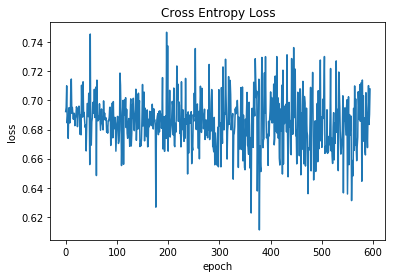

In [54]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

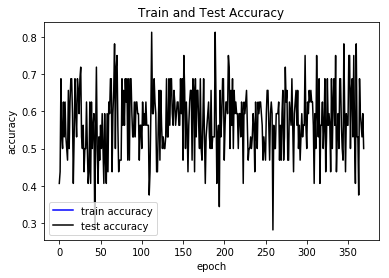

In [55]:
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()